### QUESTION: Which songs have the lowest and highest overall scores?

To answer this question we will look at all songs across all algorithms.

First, we will sum their scores and sort them to find the lowest and highest scoring songs, then graph the results.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelmax, argrelmin
%matplotlib inline

In [53]:
def data_path(year, d_type='results'):
    if d_type == 'results':
        the_path = os.path.join(os.path.expanduser("~"),'Documents', 'school', 'CSC', '475', 'project', 
                                'datasets', str(year), 'result_sets')
    elif d_type == 'groundtruth':
        the_path = os.path.join(os.path.expanduser("~"),'Documents', 'school', 'CSC', '475', 'project', 
                                'datasets', str(year), 'ground_truth')
    elif d_type == 'outputs':
        the_path = os.path.join(os.path.expanduser("~"),'Documents', 'school', 'CSC', '475', 'project', 
                                'datasets', str(year), 'outputs')
    assert os.path.isdir(the_path), 'no such path exists: {0}'.format(the_path)
    return the_path


def competition_files(year, d_type='results', ext='csv'):
    root = data_path(year, d_type)
    orig_dir = os.getcwd()
    os.chdir(root)
    file_struct = os.walk(root)
    comp_files = []
    for path, dirs, files in file_struct:
        for file in files:
            if ext == file.split(".")[-1]:
                comp_files.append(os.path.join(path, file))
    os.chdir(orig_dir)
    return comp_files


def competition_results(year, header=0):
    comp_results = {}
    comp_files = competition_files(year)
    songs_used = []
    for filename in comp_files:
        comp_results[filename.split("/")[-1]] = pd.read_csv(filename, header=header)

        #change values in column
        if year == 2009:
            comp_results[filename.split("/")[-1]]['filename'] = comp_results[filename.split("/")[-1]]['filename'].apply(lambda x: x.split(".")[0].lower().replace("__", "_-_"))
            songs_used = songs_used + comp_results[filename.split("/")[-1]].filename.unique().tolist()
        else:
            songs_used = songs_used + comp_results[filename.split("/")[-1]].File.unique().tolist()


    
    try:
        songs_used.remove('ave')
        songs_used.remove('weighted ave')
    except ValueError:
        pass
    
    return comp_results, np.array(list(set(songs_used)))


def songs_by_score(songs_and_sums):
    return sorted([(song, score) for song, score in songs_and_sums.items()], key=lambda x: x[1])


def summed_overlaps(comp_results, songs_used, col="Overlap_Score", file="filename"):
    # Go through each submitted algorithms results:
    songs = dict(zip(songs_used, [0]*len(songs_used)))
    for algorithm in comp_results:
        # For this algorithm, check all songs
        for idx, row in comp_results[algorithm].iterrows():
            songs[row[file]] = songs[row[file]] + row[col]
    return songs


def show_top_bottom_ten(overlap_sums, year):
    t = list(overlap_sums.items())
    t.sort(key=lambda x: x[1])

    plt.figure(figsize=(15,5))
    #plot bottom 10:
    plt.plot(range(10), [score for song, score in t[:10]])
    #plot top 10:
    plt.plot(range(10, 20), [score for song, score in t[-10:]])    
    plt.ylabel("Total overlap, year {0}".format(year))
    plt.xlabel("Song")
    
    song_labels = [song for song, score in t[:10]] + [song for song, score in t[-10:]]
    #plot song labels for bottom & top ten:
    plt.xticks(range(20), song_labels, rotation='vertical')
    
    plt.title("Lowest and Highest 10 Songs, year {0}".format(year))
    plt.show()
    return t
    
    
def show_all_scores(overlap_sums, year):
    values = np.array(list(overlap_sums.values()))

    plt.figure(figsize=(20,20))
    plt.plot(range(len(overlap_sums)), values)

    plt.ylabel("Total overlap, year {0}".format(year))
    plt.xlabel("Song")
    plt.title("Total Overlap Score for All Songs, year {0}".format(year))
    plt.show()

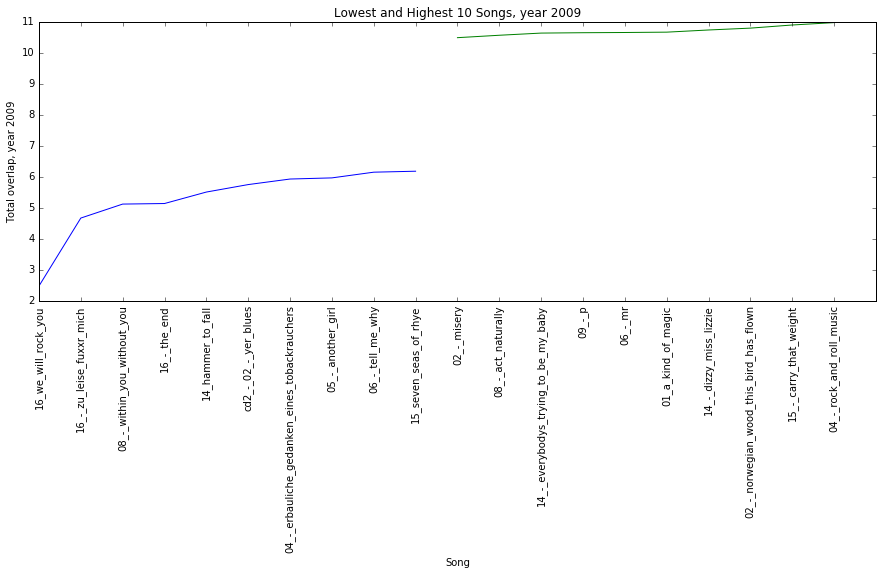

In [55]:
results_2009, songs_2009 = competition_results(2009)
overlap_sums_2009 = summed_overlaps(results_2009, songs_2009)
#show_all_scores(overlap_sums_2009, 2009)
sorted_song_totals_2009 = show_top_bottom_ten(overlap_sums_2009, 2009)
#top_env_idx_2009 = argrelmax(np.array(list(overlap_sums.values())))[0]
#bottom_env_idx_2009 = argrelmin(np.array(list(overlap_sums.values())))[0]

Here we have both the top 10 songs by overall score, as well as the bottom 10. Scores here are totalled across all submitted algorithms.

The next question to answer is, do these songs have anything in common? 

To investigate this we will examine the ground truth files for each of the 10 lowest and highest scorers. We will also look at the top and bottome 10 scorers in other years on the same dataset. The reasoning is that it there is something unique about the song that makes it difficult to predict the chords therein, that difficulty will persist across time. If not, then it can be concluded as a failing of the 2009 submissions.

Unfortunately, MIREX decided to change how it runs the competition after 2009. They claim to be using the same dataset, however now all of the songs have been relabled things like 'chord_mrx_09_000001', making it impossible to determine if the same songs have the lowest overlap score in subsequent years. Also, the overlap score is no-longer provided.

### QUESTION: How to the overlaps compare across algorithms?

To answer this question we will order the songs alphabetically and plot the score for each, by algorithm. Then, we will overlay the plots to see the change in each algorithm's predictive powers over the set.

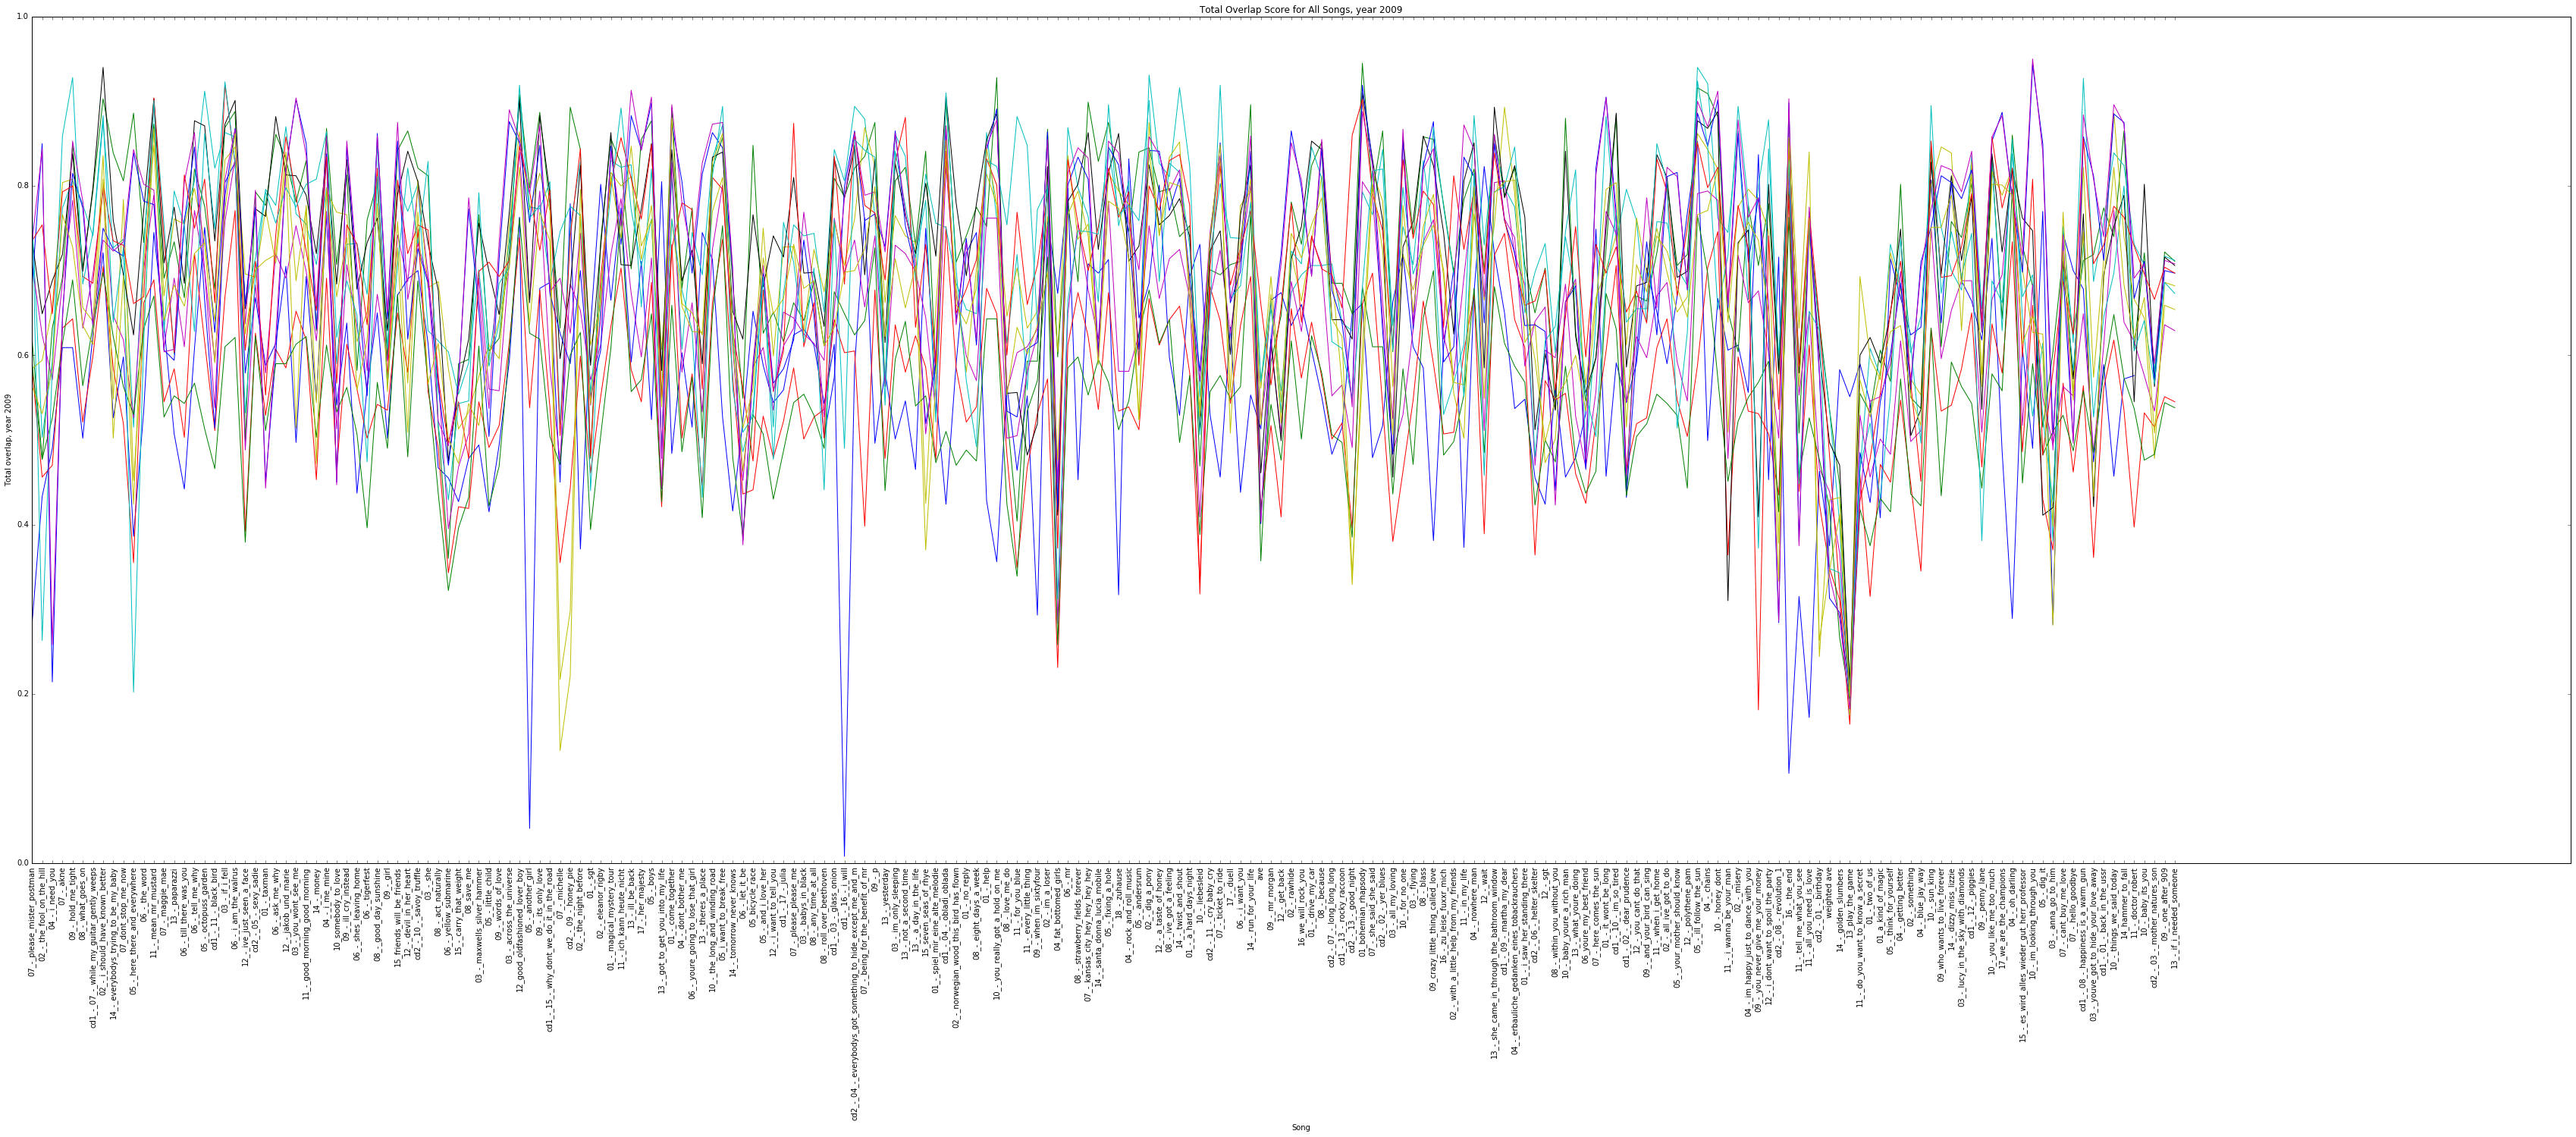

In [43]:
def compare_all_algo_overlaps(competition_results, songs, year, col="Overlap_Score"):
    plt.figure(figsize=(60,20))
    for result_set in competition_results.values():
        #iter through each algo 
        #plot this algo's overlap score.
        
        #get the overlap scores for this algo in a numpy array:
        overlaps = result_set[col].as_matrix()
        end = overlaps.shape[0]
        plt.plot(range(end), overlaps)

    plt.ylabel("Total overlap, year {0}".format(year))
    plt.xlabel("Song")
    plt.title("Total Overlap Score for All Songs, year {0}".format(year))
    plt.xticks(range(end), [song for song in songs], rotation='vertical')
    plt.show()
    
compare_all_algo_overlaps(results_2009, songs_2009, 2009)

What we observe here is that many of the peaks and valleys are shared across submissions. In other words, these differing algorithms all have trouble or ease with the same songs, generally speaking.  


Let's find out what songs are a local minimum for all 13 submissions at the same time.

In [5]:
def bad_score_by_most_submissions(competition_results, songs, year, cutoff):
        min_idxes = []
        
        song_idx = []
        
        for result_set in competition_results.values():
            
            algos_min_idxes = argrelmin(np.array(list(result_set.Overlap_Score.tolist())))[0]
            
            for idx in algos_min_idxes:
                min_idxes.append(idx)
                    
        for idx in min_idxes:
            if min_idxes.count(idx) >= cutoff and idx not in song_idx:
                song_idx.append(idx)
        
        return songs[song_idx]

In [6]:
common_bad_songs_2009 = bad_score_by_most_submissions(results_2009, 
                                                      songs_2009, 
                                                      2009, 
                                                      13)

for song in common_bad_songs_2009:
    print(song)

cd1_-_11_-_black_bird
09_-_girl
04_fat_bottomed_girls
13_play_the_game
09_-_penny_lane


Let's investigate whether or not these songs have something in common and if this is why most algorithms submitted did poorly on them

In [7]:
def ground_truth(year):
    ground_truth = {}
    truth_files = competition_files(year, d_type='groundtruth', ext='lab')
    for filename in truth_files:
        ground_truth[filename.split("/")[-1].split(".")[0].lower().replace("\'", "")] = pd.read_csv(filename, sep=" ",
                                                            names=['onset', 'offset', 'chord'])
    return ground_truth

In [8]:
ground_truth_2009 = ground_truth(2009)

In [9]:
#print(common_bad_songs_2009[0])
#ground_truth_2009['01_']
ground_truth_2009[common_bad_songs_2009[0]]

result = pd.concat([df.chord for df in ground_truth_2009.values()], axis=1)

In [10]:
result

,chord,chord,chord,chord,chord,chord,chord,chord,chord,chord,...,chord,chord,chord,chord,chord,chord,chord,chord,chord,chord
0,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,E,N,N,N,N
1,C#:min,Db,A,F,B,G,E,D,E,E:7,...,E:(1),E,F,A:min,D,E/b7,G,B:min,D:maj6,A
2,F#:min,Gb,A:sus2,C,E,D,B,B:min,A/3,A,...,A:min7,E:7,A:min/5,A:min,G,E/6,E:min,D/5,D:maj6,A
3,A,Ab,A:sus4,F,B,G,F#,D,A:maj(*5),E,...,A:min6,A,A:dim/b5,E:min,D,E/5,G,G#:hdim7,G:maj6/3,G:maj/9
4,F#:min,Db,A,Bb,E,D,B,B:min,N,B:9,...,E:min(9),D,D:(1),A:min,G,A,E:min,E:9,D,A
5,D,Db,A,G,E,G,F#,D,E,A,...,E:min,C,Bb,E:min,C,D,G,D,G:maj6/3,G:maj/9
6,E,Db,D,C,A,D,E:7,B:min,A/3,E,...,A:min7,D,Bb,A:min,D,A,E:min,D:sus4,E:min,A
7,A,Ab,A,F,E,G,A,D,A:maj(*5),E:7,...,A:min6,A,F,E:min,G,D,C,D:maj(9),A,E:min
8,F#:min,Ab,A:sus2,Bb,A,D,F#:7,B:min,N,A,...,E:min(9),D,Bb,A:min,D/3,A,G,D,D:maj6,F#
9,D,Db,A:sus4,G,B:sus4,G,B:7,D,E,E,...,E:min,C,Eb,E:min,E:min,D,C,D,B:min7,B:min


I see a lot of chords in minor keys. I am beginning to wonder if this has something to do with it?

I could look into the average amount of min/major/dim/#/and any chord modified with a number -- then I can check if this 5 songs differ in some way from the norm.

### QUESTION: What is the average score of each algorithm?

### QUESTION: What is the highest average scoring algorithm?

### QUESTION: By how much is it better?

### QUESTION: How much better is the average score when you choose the best algorithm each time?

### QUESTION: Is they any way to predict which guess is best out of all?

In [11]:
#What is the average score of each algorithm? (overlap score)
def algorithms_ave(results):
    averages = []
    
    for algorithm in results.keys():
        averages.append((algorithm, results[algorithm].loc[results[algorithm]['filename'] == 'ave'].Overlap_Score.tolist()[0]))

    return sorted(averages, key=lambda x: x[1], reverse=True)

In [12]:
averages_2009 = algorithms_ave(results_2009)

In [13]:
# What is the highest-averaged algorithm?
averages_2009[0]

('OGF2.task1.overlap.results.csv', 0.72199999999999998)

In [14]:
# How much better is the best average?
averages_2009[1]

('MD.task1.overlap.results.csv', 0.71700000000000008)

In [15]:
# Whats the average when you choose the best algorithm for each song?
def best_algo(results, songs):
    test = []
    for song in songs:
        test.append([])

        for algo in results.keys():
            try:
                test[-1].append(results[algo].loc[results[algo]['filename'] == song].Overlap_Score.tolist()[0])
            except IndexError:
                pass
    return [max(rank) for rank in test]

highest_rankings = best_algo(results_2009, songs_2009)

# the average you get if you always choose the best algorithm for each song.
print(np.average(highest_rankings))

0.798358490566


Is there any way to predict which algorithm is best when you run all of them?
I have the overlap values, so I cannot look into this for 2009. I'll try 2011.

# MIREX 2011; using different stats

For the remainder of this project only the major/minor vocabulary will be considered (MIREX decided to use multiple vocabularies -- essentially multiple ways to round chord approximations -- for the results from this year forward.

They further decided to include additional songs into the dataset, and to relabel all of the songs making cross comparision with 2009 impossible.

In [16]:
results_2011, songs_2011 = competition_results(2011, header=1)

In [23]:
# what columns do we have?
print(*results_2011['CB3.csv'].columns.values, sep=", ", end="")

File, Pairwise score (%), Duration (s), All correct (%), Root correct (%), Type correct (%), All wrong (%), Unique ref chords, Unique test chords

In [35]:
# What is the average pairwise score for each algorithm?
def pairwise_averages(submissions, year):
    averages = []
    for submission in submissions.keys():
        averages.append((submission, np.average(submissions[submission]['Pairwise score (%)'])))
    return sorted(averages, key=lambda x: x[1], reverse=True)

In [29]:
# Why is SB8.csv so bad?
results_2011['SB8.csv']

,File,Pairwise score (%),Duration (s),All correct (%),Root correct (%),Type correct (%),All wrong (%),Unique ref chords,Unique test chords
0,chord_mrx_09_000000,7.195279,164.310204,7.106907,0.000000,70.430939,20.385091,5,2
1,chord_mrx_09_000001,52.759570,200.129245,52.681304,0.000000,44.123252,0.000000,1,2
2,chord_mrx_09_000002,1.576387,182.143129,1.483939,0.000000,66.615397,28.709145,5,2
3,chord_mrx_09_000003,11.044484,153.469388,10.932808,0.000000,83.055223,0.000000,4,2
4,chord_mrx_09_000004,9.607959,236.088889,9.529460,0.000000,71.812197,16.271073,13,2
5,chord_mrx_09_000005,0.074933,194.841000,0.000000,0.000000,58.720187,32.270929,12,2
6,chord_mrx_09_000006,19.019114,183.771429,18.938346,0.000000,78.085743,0.000000,4,2
7,chord_mrx_09_000007,11.487391,112.875102,11.341121,0.000000,63.319890,20.252870,8,2
8,chord_mrx_09_000008,14.138102,172.329805,14.033722,0.000000,66.378449,16.431711,10,2
9,chord_mrx_09_000009,9.023314,164.022857,8.911832,0.000000,73.425121,17.006623,8,2


In [30]:
results_2015, songs_2015 = competition_results(2015, header=1)

In [33]:
print(*results_2015['CM3.csv'].columns.values, sep=", ", end="")

File, Pairwise score (%), Duration (s), Correct chords (%), Substituted chords (%), Deleted chords (%), Inserted chords (%), Correct no-chords (%), maj correct (%), maj proportion (%), min correct (%), min proportion (%), 0 chromas wrong (%), 1 chroma wrong (%), 2 chromas wrong (%), 3 chromas wrong (%), Both correct (%), Only root correct (%), Only type correct (%), Both wrong (%), Unique ref chords, Unique test chords

In [40]:
print("2011")
pairwise_ave_2011 = pairwise_averages(results_2011, 2011)

print("Average pairwise score, by submission:\n")
for team, ave in pairwise_ave_2011:
    print("\t", team, ": ", ave)

print("\nAverage pairwise score, overall:\n")
print(np.average([ave for team, ave in pairwise_ave_2011]))


print("\n\n2015")
pairwise_ave_2015 = pairwise_averages(results_2015, 2015)
print("Average pairwise score, by submission:\n")
for team, ave in pairwise_ave_2015:
    print("\t", team, ": ", ave)

print("\nAverage pairwise score, overall\n")
print(np.average([ave for team, ave in pairwise_ave_2015]))

2011
Average pairwise score, by submission:

	 KO1.csv :  83.0884868341
	 CB4.csv :  82.9067395484
	 CB3.csv :  82.3049815161
	 NMSD2.csv :  81.9755760276
	 NMSD1.csv :  81.3272498479
	 KO2.csv :  80.4467090645
	 NG1.csv :  76.3820656912
	 CF2.csv :  76.1563450737
	 PP3.csv :  76.131154576
	 PP4.csv :  73.7860588664
	 NG2.csv :  71.7758610415
	 SB8.csv :  7.26376459447

Average pairwise score, overall:

72.7954160568


2015
Average pairwise score, by submission:

	 KO1.csv :  83.0884868341
	 DK9.csv :  77.8503528525
	 DK8.csv :  76.9473918802
	 DK7.csv :  76.9473918802
	 DK6.csv :  76.5584058111
	 DK5.csv :  74.1535448525
	 DK4.csv :  68.5614606083
	 CM3.csv :  55.3696745484

Average pairwise score, overall

73.6845886584


Here we see that the highest average pairwise score didn't increase at all from 2011 to 2015.  We further see that the overall average of all submissions increased by a mere 0.9%. Finally, we see that this is due to the worst submission from 2011 (SB8.csv) not resubmitting for the 2015 contest. In other words, the algorithms didn't get better, instead, the worst were simply excluded.

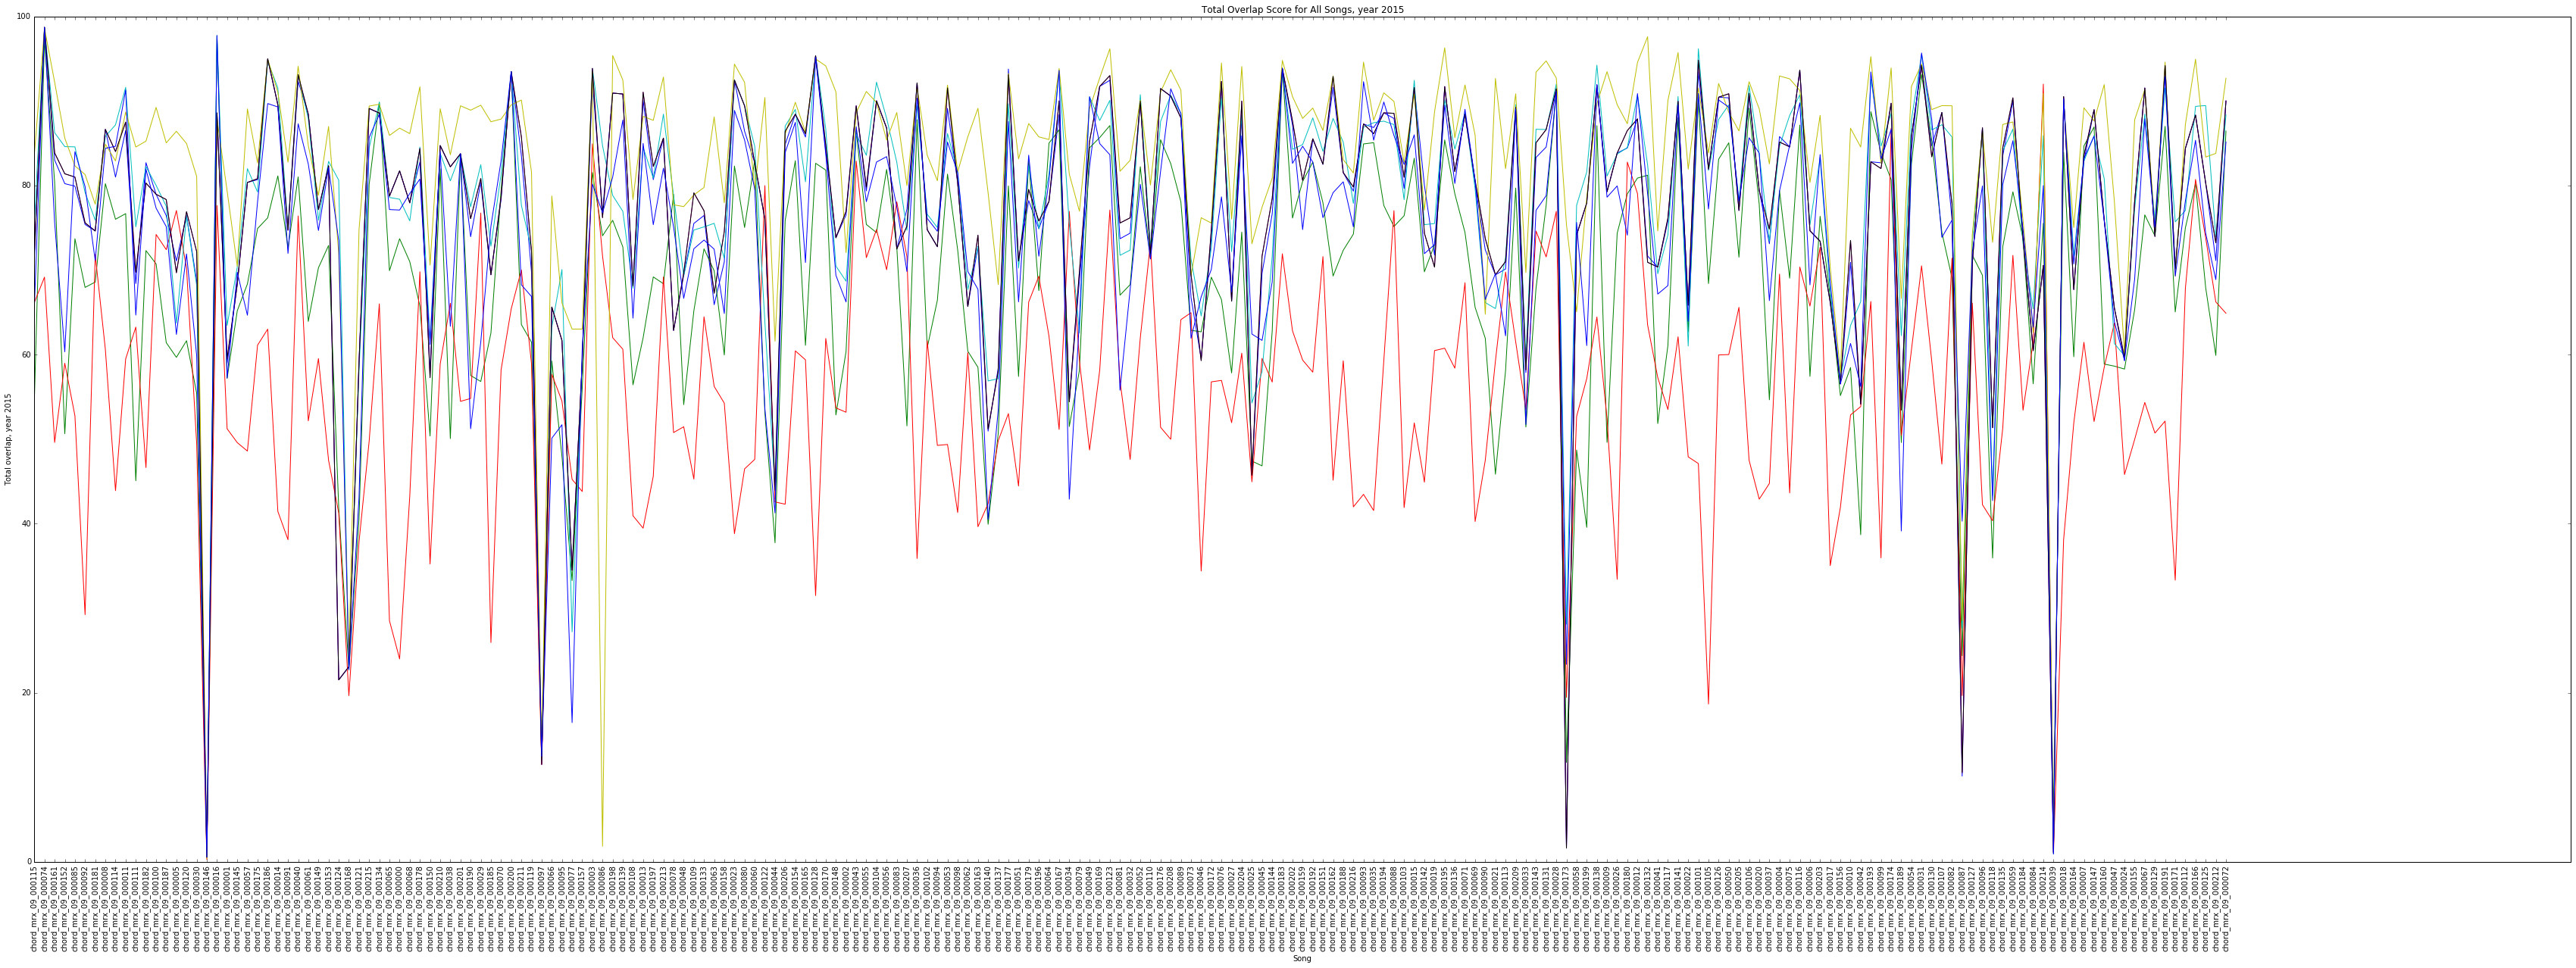

In [44]:
compare_all_algo_overlaps(results_2015, songs_2015, 2015, col='Pairwise score (%)')

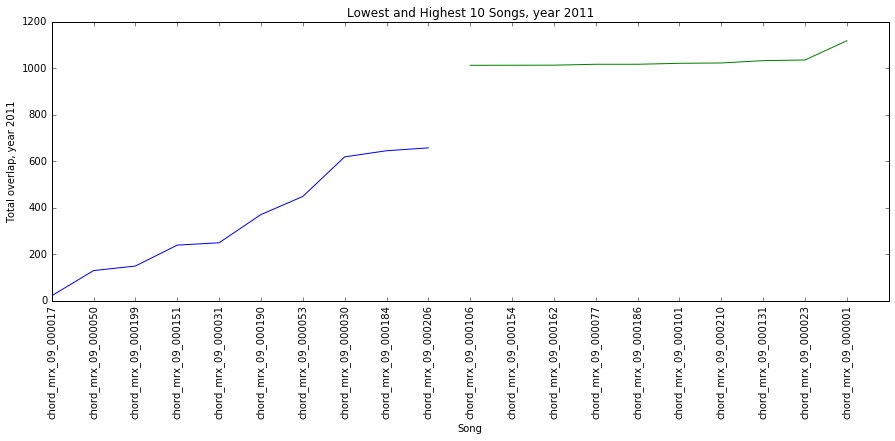

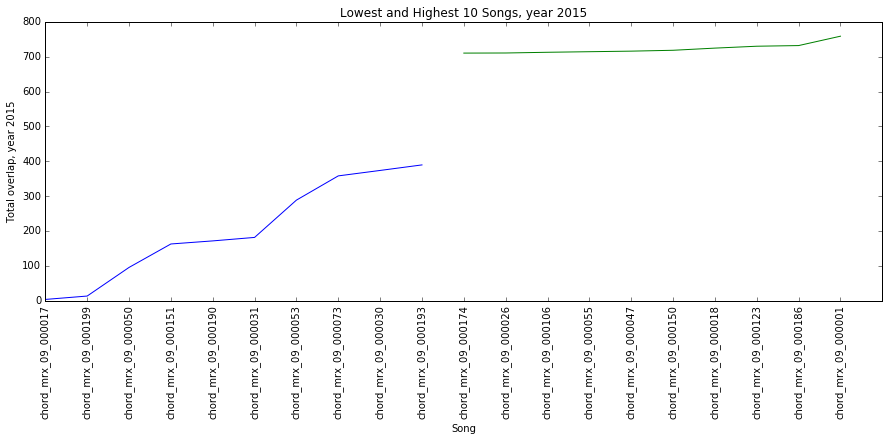

In [56]:
overlap_sums_2011 = summed_overlaps(results_2011, songs_2011, col='Pairwise score (%)', file="File")
sorted_song_totals_2011 = show_top_bottom_ten(overlap_sums_2011, 2011)

overlap_sums_2015 = summed_overlaps(results_2015, songs_2015, col='Pairwise score (%)', file="File")
sorted_song_totals_2015 = show_top_bottom_ten(overlap_sums_2015, 2015)

In [61]:
def common_songs(yearx, yeary):
    common_songs = []
    songsx = [song for song, score in yearx]
    songsy = [song for song, score in yeary]
    for song in songsx:
        if song in songsy:
            common_songs.append(song)
    return common_songs
    

In [64]:
print(common_songs(sorted_song_totals_2015[:10], sorted_song_totals_2011[:10]))

['chord_mrx_09_000017', 'chord_mrx_09_000199', 'chord_mrx_09_000050', 'chord_mrx_09_000151', 'chord_mrx_09_000190', 'chord_mrx_09_000031', 'chord_mrx_09_000053', 'chord_mrx_09_000030']


Here we see that 8 of the bottom 10 songs (when their total pairwise scores are tallied) persist from 2011 to 2015. This suggests either: these songs are inherently difficult, or, the submissions are overfit to the dataset.

### QUESTION: What are the mistakes made on these songs?

Here I will compare the ground truth file with the output of each submission, and look for common mistakes.